# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = 48 # hours used to predict next values in future
FUTURE_TARGET = 13 # number of hours to predict 
STEP = 1
BATCH_SIZE = 32

path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat.csv")

path_save_pred_vals = "data/pred_vals.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

In [2]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

## Load raw features

In [3]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,nb_time_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1.609459e+12,736.42,739.00,729.33,734.07,27932.69884,2021-01-01 00:00:00,0.0,2287.276878,2279.831289,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1.609463e+12,734.08,749.00,733.37,748.28,52336.18779,2021-01-01 01:00:00,1.0,2287.276878,2279.831289,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1.609466e+12,748.27,749.00,742.27,744.06,33019.50100,2021-01-01 02:00:00,2.0,2287.276878,2279.831289,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1.609470e+12,744.06,747.23,743.10,744.82,17604.80859,2021-01-01 03:00:00,3.0,2287.276878,2279.831289,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1.609474e+12,744.87,747.09,739.30,742.29,18794.15424,2021-01-01 04:00:00,4.0,2287.276878,2279.831289,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19794,1.680718e+12,1898.14,1900.48,1891.10,1900.13,12135.48310,2023-04-05 18:00:00,19794.0,1840.782500,1827.340000,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
19795,1.680721e+12,1900.13,1918.00,1892.88,1909.19,26496.41630,2023-04-05 19:00:00,19795.0,1843.030000,1827.340000,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
19796,1.680725e+12,1909.18,1915.36,1903.00,1905.75,14370.63690,2023-04-05 20:00:00,19796.0,1845.055000,1827.340000,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
19797,1.680728e+12,1905.74,1911.42,1905.74,1911.32,6258.60600,2023-04-05 21:00:00,19797.0,1845.522500,1827.340000,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [4]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_ETH            1
vwap_z_score_BTC            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
max_high_h_ETH             13
max_high_h_BTC             13
chop_h_BTC                 13
chop_h_ETH                 13
rsi_h_BTC                  13
min_low_h_ETH              13
rsi_h_ETH                  13
min_low_h_BTC              13
ichi_cloud_a_BTC           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_ETH           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
dxy                      1109
fvx                      1117
spx                     

<AxesSubplot: >

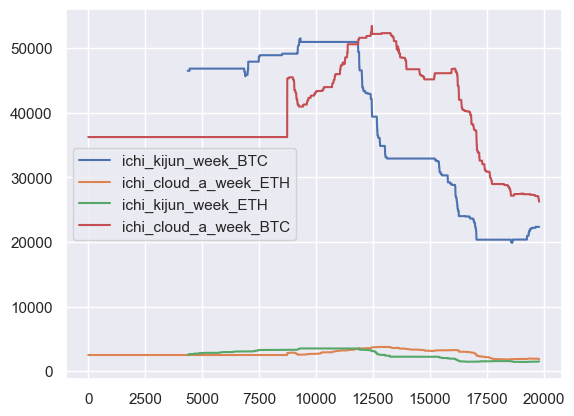

In [5]:
df_feat_raw[["ichi_kijun_week_BTC"   ,    
"ichi_cloud_a_week_ETH"   ,  
"ichi_kijun_week_ETH"    ,   
"ichi_cloud_a_week_BTC"]].plot()

### drop nan

In [6]:
print(df_feat_raw.shape)
df_feat = df_feat_raw.dropna(subset=["ichi_kijun_week_ETH"]).copy()
df_feat.reset_index(inplace=True)
df_feat.shape

(19799, 138)


(15432, 139)

In [7]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       15355
delta_event_real    15355
delta_event_pred    15355
Previous_num        15355
Actual_num          15355
Event               15355
Date                15355
Previous            15355
Consensus           15355
Actual              15355
Country             15355
Time (ET)           15355
keep                15355
date                15355
dtype: int64

on 15432 samples


In [8]:
df_feat

,index,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,nb_time_ETH,ichi_cloud_a_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,4367,1.625180e+12,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,4367.0,2188.2400,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,4368,1.625184e+12,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,4368.0,2188.2400,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,4369,1.625188e+12,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,4369.0,2188.2400,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,4370,1.625191e+12,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,4370.0,2189.4400,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,4371,1.625195e+12,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,4371.0,2192.3925,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15427,19794,1.680718e+12,1898.14,1900.48,1891.10,1900.13,12135.48310,2023-04-05 18:00:00,19794.0,1840.7825,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
15428,19795,1.680721e+12,1900.13,1918.00,1892.88,1909.19,26496.41630,2023-04-05 19:00:00,19795.0,1843.0300,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
15429,19796,1.680725e+12,1909.18,1915.36,1903.00,1905.75,14370.63690,2023-04-05 20:00:00,19796.0,1845.0550,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
15430,19797,1.680728e+12,1905.74,1911.42,1905.74,1911.32,6258.60600,2023-04-05 21:00:00,19797.0,1845.5225,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


## Features Selection

### Propotional to the Price

In [9]:
list_col = df_feat.columns.to_list()
list_col

['index',
 'Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'nb_time_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_

In [10]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'nb_time_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [11]:
df_feat[list_col_ETH]

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,nb_time_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,vwap_m_ETH,vwap_3m_ETH,vwap_6m_ETH,vwap_y_ETH,vwap_all_ETH,vwap_z_score_ETH,nupl_ETH,supply_ETH,act_addr_ETH,market_dom_ETH
0,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,4367.0,2188.2400,2174.775,2177.520,...,1997.879913,1997.879913,1997.879913,1997.879913,1997.879913,0.154972,0.051524,1.166929e+08,527404.0,17.798166
1,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,4368.0,2188.2400,2174.775,2177.520,...,1997.892763,1997.892763,1997.892763,1997.892763,1997.892763,0.196056,0.064298,1.167074e+08,501748.0,17.561982
2,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,4369.0,2188.2400,2174.775,2174.525,...,1997.906443,1997.906443,1997.906443,1997.906443,1997.906443,0.127732,0.042846,1.167074e+08,501748.0,17.561982
3,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,4370.0,2189.4400,2174.775,2170.405,...,1997.914232,1997.914232,1997.914232,1997.914232,1997.914232,0.137906,0.046096,1.167074e+08,501748.0,17.561982
4,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,4371.0,2192.3925,2174.775,2149.315,...,1997.926804,1997.926804,1997.926804,1997.926804,1997.926804,0.061819,0.021200,1.167074e+08,501748.0,17.561982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15427,1898.14,1900.48,1891.10,1900.13,12135.48310,2023-04-05 18:00:00,19794.0,1840.7825,1827.340,1901.095,...,1465.076847,2142.992021,2092.193008,1576.893725,2092.193008,-0.198819,-0.101079,1.204153e+08,441466.0,18.185089
15428,1900.13,1918.00,1892.88,1909.19,26496.41630,2023-04-05 19:00:00,19795.0,1843.0300,1827.340,1901.095,...,1465.156251,2142.984587,2092.185206,1576.752296,2092.185206,-0.189436,-0.095850,1.204153e+08,441466.0,18.185089
15429,1909.18,1915.36,1903.00,1905.75,14370.63690,2023-04-05 20:00:00,19796.0,1845.0550,1827.340,1901.095,...,1465.036845,2142.982155,2092.181006,1576.664583,2092.181006,-0.192997,-0.097826,1.204153e+08,441466.0,18.185089
15430,1905.74,1911.42,1905.74,1911.32,6258.60600,2023-04-05 21:00:00,19797.0,1845.5225,1827.340,1901.095,...,1465.000096,2142.981934,2092.179191,1576.606041,2092.179191,-0.187233,-0.094625,1.204153e+08,441466.0,18.185089


In [12]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [13]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'nb_time_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [14]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [15]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB',
 'High_BNB',
 'Low_BNB',
 'Close_BNB',
 'Volume_BNB',
 'date_BNB',
 'nb_time_BNB']

In [16]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [17]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'index',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nb_time_BNB',
 'nb_time_BTC',
 'nb_time_ETH',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_scor

In [18]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [19]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global
print("num features : ", len(list_col_select))

num features :  104


In [20]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [21]:
df_feat["event_real"].describe()

count    15432.000000
mean        -0.000713
std          0.050268
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: event_real, dtype: float64

In [22]:
df_feat["event_real"].value_counts()

 0.0    15393
-1.0       25
 1.0       14
Name: event_real, dtype: int64

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [23]:
df_feat.shape[0]

15432

In [24]:
TRAIN_SPLIT = round(0.99 * df_feat.shape[0])
TRAIN_SPLIT

15278

In [25]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

,index,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,nb_time_ETH,ichi_cloud_a_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,4367,1.625180e+12,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,4367.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
1,4368,1.625184e+12,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,4368.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
2,4369,1.625188e+12,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,4369.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
3,4370,1.625191e+12,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,4370.0,2189.4400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
4,4371,1.625195e+12,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,4371.0,2192.3925,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15427,19794,1.680718e+12,1898.14,1900.48,1891.10,1900.13,12135.48310,2023-04-05 18:00:00,19794.0,1840.7825,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15428,19795,1.680721e+12,1900.13,1918.00,1892.88,1909.19,26496.41630,2023-04-05 19:00:00,19795.0,1843.0300,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15429,19796,1.680725e+12,1909.18,1915.36,1903.00,1905.75,14370.63690,2023-04-05 20:00:00,19796.0,1845.0550,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15430,19797,1.680728e+12,1905.74,1911.42,1905.74,1911.32,6258.60600,2023-04-05 21:00:00,19797.0,1845.5225,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [26]:
df_feat[df_feat["train"] == True]

,index,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,nb_time_ETH,ichi_cloud_a_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,4367,1.625180e+12,2128.88,2135.07,2104.88,2106.41,20782.46239,2021-07-01 23:00:00,4367.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
1,4368,1.625184e+12,2106.41,2136.00,2096.00,2135.18,22888.95033,2021-07-02 00:00:00,4368.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
2,4369,1.625188e+12,2135.50,2139.00,2084.04,2087.34,28744.05686,2021-07-02 01:00:00,4369.0,2188.2400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
3,4370,1.625191e+12,2087.45,2103.64,2082.00,2094.46,18099.07919,2021-07-02 02:00:00,4370.0,2189.4400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
4,4371,1.625195e+12,2094.45,2095.74,2033.96,2041.20,47236.16323,2021-07-02 03:00:00,4371.0,2192.3925,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15274,19641,1.680167e+12,1799.13,1801.53,1793.40,1800.63,14743.22400,2023-03-30 09:00:00,19641.0,1779.0850,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
15275,19642,1.680170e+12,1800.64,1806.00,1798.27,1803.53,11582.38440,2023-03-30 10:00:00,19642.0,1784.5825,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
15276,19643,1.680174e+12,1803.52,1807.27,1801.74,1804.62,11504.45340,2023-03-30 11:00:00,19643.0,1785.2150,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
15277,19644,1.680178e+12,1804.62,1805.88,1797.05,1804.21,16682.87890,2023-03-30 12:00:00,19644.0,1785.2150,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True


In [27]:
df_feat[df_feat["train"] == False]

,index,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,nb_time_ETH,ichi_cloud_a_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
15279,19646,1.680185e+12,1797.69,1798.72,1786.50,1795.01,27531.9631,2023-03-30 14:00:00,19646.0,1787.8400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15280,19647,1.680188e+12,1795.00,1796.61,1784.18,1789.42,27665.6578,2023-03-30 15:00:00,19647.0,1792.4175,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15281,19648,1.680192e+12,1789.41,1791.82,1778.64,1785.56,31185.2255,2023-03-30 16:00:00,19648.0,1792.4175,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15282,19649,1.680196e+12,1785.56,1787.42,1763.00,1770.18,40953.1550,2023-03-30 17:00:00,19649.0,1793.9400,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15283,19650,1.680199e+12,1770.19,1777.02,1767.21,1776.60,17891.6033,2023-03-30 18:00:00,19650.0,1793.8025,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15427,19794,1.680718e+12,1898.14,1900.48,1891.10,1900.13,12135.4831,2023-04-05 18:00:00,19794.0,1840.7825,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15428,19795,1.680721e+12,1900.13,1918.00,1892.88,1909.19,26496.4163,2023-04-05 19:00:00,19795.0,1843.0300,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15429,19796,1.680725e+12,1909.18,1915.36,1903.00,1905.75,14370.6369,2023-04-05 20:00:00,19796.0,1845.0550,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
15430,19797,1.680728e+12,1905.74,1911.42,1905.74,1911.32,6258.6060,2023-04-05 21:00:00,19797.0,1845.5225,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [28]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [29]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [30]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [31]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15218, 48, 104) (15218, 13)
(92, 48, 104) (92, 13)


In [32]:
X_train

array([[[0.95500213, 0.96518956, 0.96799597, ..., 0.        ,
         0.        , 0.        ],
        [0.96804585, 0.95500213, 0.96841762, ..., 0.        ,
         0.        , 0.        ],
        [0.94635619, 0.96819093, 0.96977775, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.00681882, 1.00893157, 1.01046852, ..., 0.        ,
         0.        , 0.        ],
        [0.99350308, 1.00681882, 1.00984739, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99378417, 1.0019586 , ..., 0.        ,
         0.        , 0.        ]],

       [[0.95877395, 0.94585517, 0.95914216, ..., 0.        ,
         0.        , 0.        ],
        [0.93729204, 0.95891764, 0.96048927, ..., 0.        ,
         0.        , 0.        ],
        [0.94048918, 0.93734143, 0.94461134, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.98398736, 0.99717556, 1.00017512, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [33]:
seq_y

array([0.99564434, 0.99889575, 1.01323429, 0.99698283, 1.00209139,
       1.00226427, 1.0017233 , 1.00747322, 1.0033741 , 1.00421623,
       1.00583357, 1.00644147, 1.00621281])

In [34]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [0.99772095, 0.99914187, 0.99478995, ..., 1.00251308, 1.00335449,
        1.00497044],
       [1.00142417, 0.99706231, 1.00031834, ..., 1.0056464 , 1.00726605,
        1.00787481],
       [0.99564434, 0.99889575, 1.01323429, ..., 1.00583357, 1.00644147,
        1.00621281]])

In [35]:
seq_y

array([0.99564434, 0.99889575, 1.01323429, 0.99698283, 1.00209139,
       1.00226427, 1.0017233 , 1.00747322, 1.0033741 , 1.00421623,
       1.00583357, 1.00644147, 1.00621281])

In [36]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [0.99772095, 0.99914187, 0.99478995, ..., 1.00251308, 1.00335449,
        1.00497044],
       [1.00142417, 0.99706231, 1.00031834, ..., 1.0056464 , 1.00726605,
        1.00787481],
       [0.99564434, 0.99889575, 1.01323429, ..., 1.00583357, 1.00644147,
        1.00621281]])

In [37]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [38]:
X_train.shape

(15218, 48, 104)

In [39]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(15218, 48, 104) (15218, 13)
(92, 48, 104) (92, 13)


## Standardization

In [40]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

In [41]:
#scaler_y = StandardScaler()
#y_train_sca = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
#y_test_sca = scaler_y.transform(y_test.reshape(-1,y_test.shape[-1])).reshape(y_test.shape)

scaler_y = StandardScaler()
y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [42]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [0.99772095, 0.99914187, 0.99478995, ..., 1.00251308, 1.00335449,
        1.00497044],
       [1.00142417, 0.99706231, 1.00031834, ..., 1.0056464 , 1.00726605,
        1.00787481],
       [0.99564434, 0.99889575, 1.01323429, ..., 1.00583357, 1.00644147,
        1.00621281]])

In [43]:
np.mean(y_train_sca)

1.8401977217972892e-15

In [44]:
np.std(y_train_sca)

1.0

### Check unscaling

In [45]:
df_feat[list_col_select].head(10)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,month_cos,month_sin,day_off,event_pred,event_real
0,2106.41,2128.88,2135.07,2104.88,2188.2400,2174.775,2177.520,2107.755,2793.485,3050.73,...,-0.258819,-0.900969,0.433884,0.979530,0.201299,-0.866025,-0.5,0.0,0.0,0.0
1,2135.18,2106.41,2136.00,2096.00,2188.2400,2174.775,2177.520,2107.755,2793.485,3050.73,...,0.000000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
2,2087.34,2135.50,2139.00,2084.04,2188.2400,2174.775,2174.525,2107.755,2793.485,3050.73,...,0.258819,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
3,2094.46,2087.45,2103.64,2082.00,2189.4400,2174.775,2170.405,2107.755,2793.485,3050.73,...,0.500000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
4,2041.20,2094.45,2095.74,2033.96,2192.3925,2174.775,2149.315,2086.980,2793.485,3050.73,...,0.707107,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
5,2054.86,2041.19,2058.85,2035.61,2203.5250,2174.775,2134.385,2086.980,2793.485,3050.73,...,0.866025,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
6,2032.84,2054.86,2058.77,2023.41,2211.6375,2180.675,2129.110,2081.705,2793.485,3050.73,...,0.965926,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
7,2034.03,2032.92,2041.86,2018.50,2210.8925,2185.445,2126.655,2078.750,2793.485,3050.73,...,1.000000,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
8,2061.49,2034.35,2070.00,2028.98,2210.8925,2185.445,2126.655,2078.750,2793.485,3050.73,...,0.965926,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0
9,2060.50,2061.49,2080.46,2051.48,2203.1750,2186.930,2094.295,2078.750,2793.485,3050.73,...,0.866025,-0.900969,-0.433884,0.918958,0.394356,-0.866025,-0.5,0.0,0.0,0.0


In [46]:
df_feat["Close_ETH"].iloc[0:10]

0    2106.41
1    2135.18
2    2087.34
3    2094.46
4    2041.20
5    2054.86
6    2032.84
7    2034.03
8    2061.49
9    2060.50
Name: Close_ETH, dtype: float64

In [47]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [48]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [2106.41 2135.18 2087.34 2094.46 2041.2  2054.86 2032.84 2034.03 2061.49
 2060.5 ]
X_train_raw:      [2106.41 2135.18 2087.34 2094.46 2041.2  2054.86 2032.84 2034.03 2061.49
 2060.5 ]


In [49]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
X test         :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
unscaled to raw:  [1795.01 1789.42 1785.56 1770.18 1776.6  1781.62 1795.23 1792.8  1784.47
 1793.61]
X_test_raw     :  [1795.01 1789.42 1785.56 1770.18 1776.6  1781.62 1795.23 1792.8  1784.47
 1793.61]


## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [50]:
X_train_sca.shape

(15218, 48, 104)

In [51]:
X_train_sca[:,-1,:].shape

(15218, 104)

In [52]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.4204277 ],
       [-0.40894103],
       [-0.21217868],
       ...,
       [-0.10763138],
       [ 0.05601529],
       [-0.19939776]])

In [53]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(15218, 105)

In [54]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

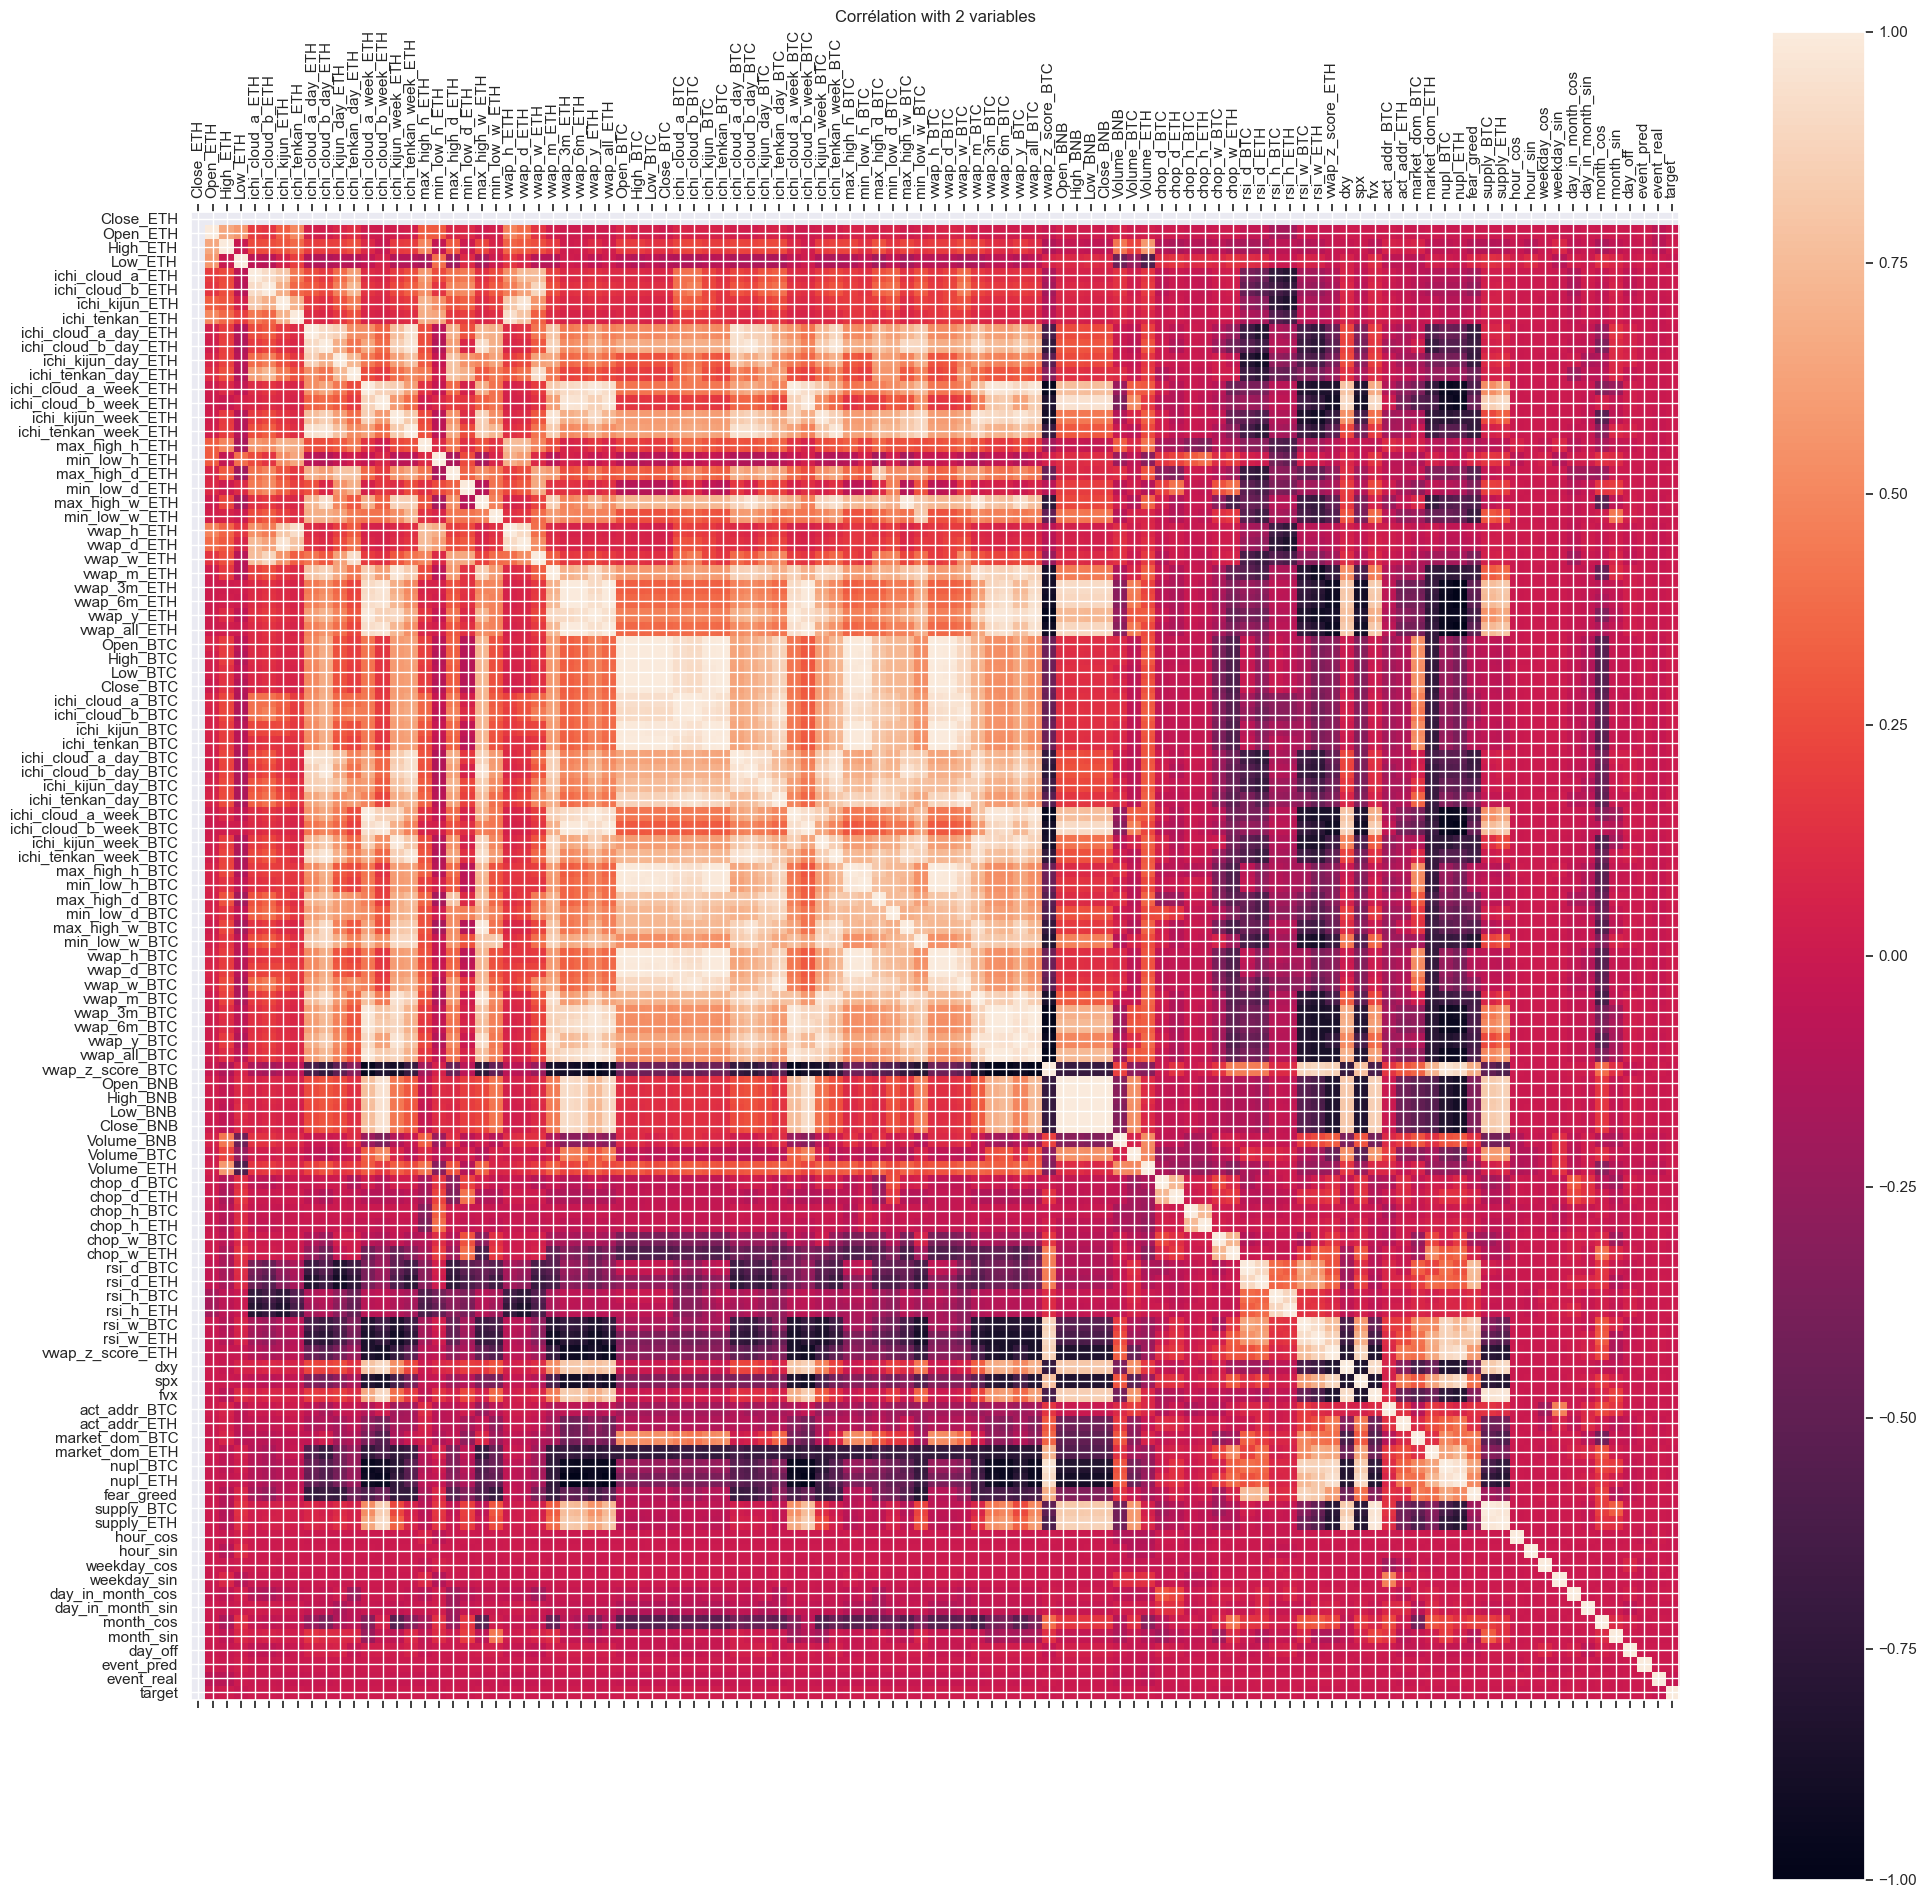

In [55]:

nb_plot = 104
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
    columns=list_col_select[:nb_plot] + ['target'])

# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(24, 24))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()


In [56]:
y_train

array([[1.00967057, 1.00048512, 0.99583798, ..., 1.05341712, 1.05926571,
        1.05681293],
       [0.99090252, 0.98629989, 0.99140095, ..., 1.04912011, 1.04669082,
        1.03601723],
       [0.99535512, 1.00050301, 1.00135948, ..., 1.0563005 , 1.0455289 ,
        1.0498022 ],
       ...,
       [0.99772095, 0.99914187, 0.99478995, ..., 1.00251308, 1.00335449,
        1.00497044],
       [1.00142417, 0.99706231, 1.00031834, ..., 1.0056464 , 1.00726605,
        1.00787481],
       [0.99564434, 0.99889575, 1.01323429, ..., 1.00583357, 1.00644147,
        1.00621281]])

In [57]:
y_train_sca

array([[ 0.4204277 ,  0.01451818, -0.19084079, ...,  2.35360685,
         2.61205862,  2.50366915],
       [-0.40894103, -0.61233308, -0.38691516, ...,  2.16372029,
         2.05636898,  1.58469787],
       [-0.21217868,  0.01530879,  0.05315662, ...,  2.48102474,
         2.00502321,  2.19386185],
       ...,
       [-0.10763138, -0.04484023, -0.23715353, ...,  0.10413486,
         0.14131707,  0.21272662],
       [ 0.05601529, -0.1367373 ,  0.00714843, ...,  0.24259782,
         0.31417048,  0.34107193],
       [-0.19939776, -0.05571665,  0.57790965, ...,  0.25086877,
         0.27773196,  0.26762746]])

## Autoencoder

In [58]:
X_train.shape

(15218, 48, 104)

### Model creation

In [59]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        plt.savefig(os.path.join(saveFolder, f"output_{title}.jpg")) 
    plt.show()

### Training

Training: units 128 - enc_dim 16 - drop 0.05 ...
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 16)          2064      
                                                                 
Total params: 121,360
Trainable params: 121,360
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
__________________________________

2023-04-06 07:18:38.881478: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


476/476 [==============================] - 21s 39ms/step - loss: 0.2123 - val_loss: 0.0948
Epoch 2/100
476/476 [==============================] - 18s 37ms/step - loss: 0.0744 - val_loss: 0.0590
Epoch 3/100
476/476 [==============================] - 18s 39ms/step - loss: 0.0526 - val_loss: 0.0585
Epoch 4/100
476/476 [==============================] - 18s 38ms/step - loss: 0.0397 - val_loss: 0.0577
Epoch 5/100
476/476 [==============================] - 18s 38ms/step - loss: 0.0343 - val_loss: 0.0597
Epoch 6/100
476/476 [==============================] - 19s 40ms/step - loss: 0.0309 - val_loss: 0.0569
Epoch 7/100
476/476 [==============================] - 19s 39ms/step - loss: 0.0283 - val_loss: 0.0562
Epoch 8/100
476/476 [==============================] - 18s 38ms/step - loss: 0.0271 - val_loss: 0.0578
Epoch 9/100
476/476 [==============================] - 18s 38ms/step - loss: 0.0250 - val_loss: 0.0519
Epoch 10/100
476/476 [==============================] - 18s 38ms/step - loss: 0.0238 

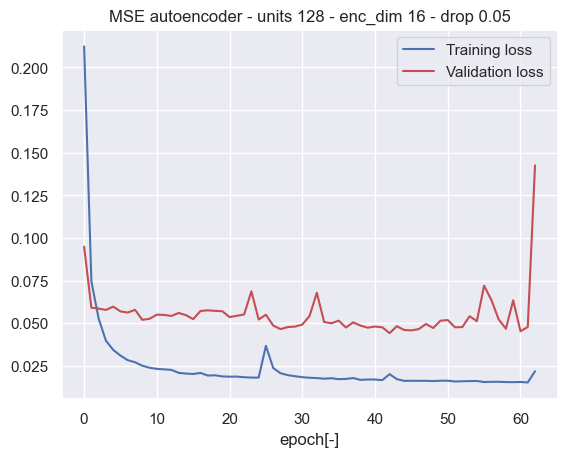

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e16_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e16_d0.05/assets


In [60]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 100 #150 #6 #300
patience = 20 #40 #3 #100
for n_unit_enc in [128]:
    for encoding_dim in [16]:
        for dropout_autoenc in [0.05]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            path_jpg = os.path.join(path_data, 
                f"output_MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}.jpg")
            if os.path.exists(path_jpg):
                continue
            print(f"Training: units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.LSTM(64, return_sequences=True)(encoder)
            #encoder = layers.LSTM(16, return_sequences=True)(encoder)
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            #decoder = layers.LSTM(16, return_sequences=True)(decoder_inputs)
            #decoder = layers.LSTM(64, return_sequences=True)(decoder)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            autoencoder.compile(optimizer="adam", loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}",
                saveFolder="data")
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")


### Save model

In [ ]:
# TODO select best model


In [61]:
autoencoder.save(path_mdl_autoencoder)
encoder_model.save(path_mdl_encoder)


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


In [63]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

476/476 [==============================] - 8s 17ms/step


(15218, 48, 104)

### Results

In [64]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

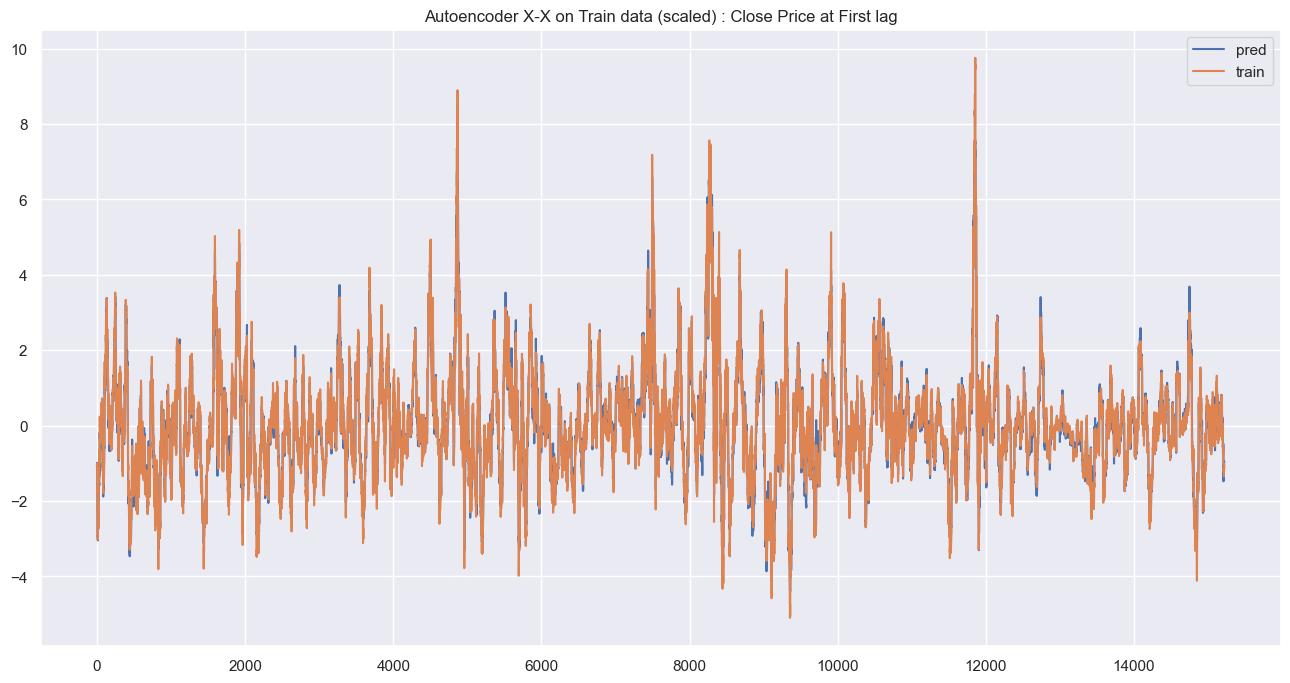

In [65]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

In [66]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(15218,)
(15218,)
[2106.41 2135.18 2087.34 ... 1709.49 1715.22 1707.56]
[2106.41 2135.18 2087.34]


In [67]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9948277, 0.9967394, 1.0061818, ..., 1.0057623, 1.002936 ,
       1.0028105], dtype=float32)

[2106.41 2135.18 2087.34 ... 1709.49 1715.22 1707.56]
[2103.96667103 2123.61184549 2116.9413024  ... 1723.19513279 1721.68421304
 1722.43793084]


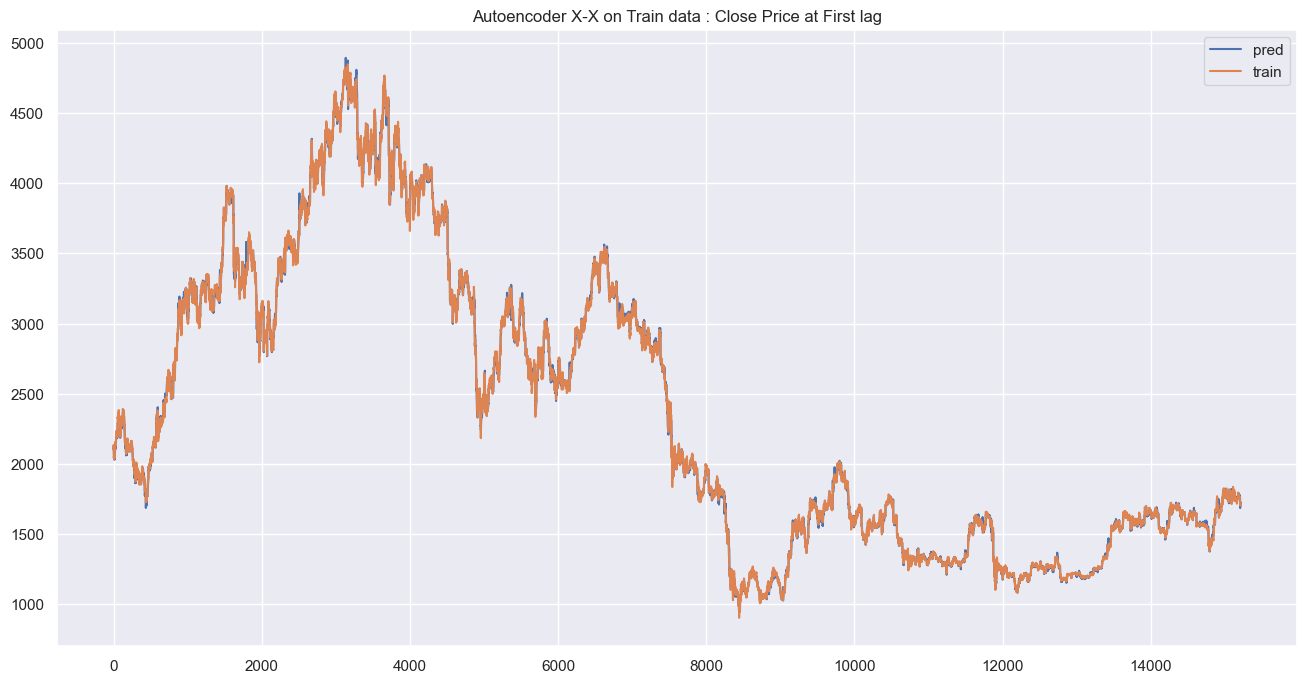

In [68]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [69]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

3/3 [==============================] - 0s 63ms/step


(92, 48, 104)

In [70]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-03-30 13:00:00'

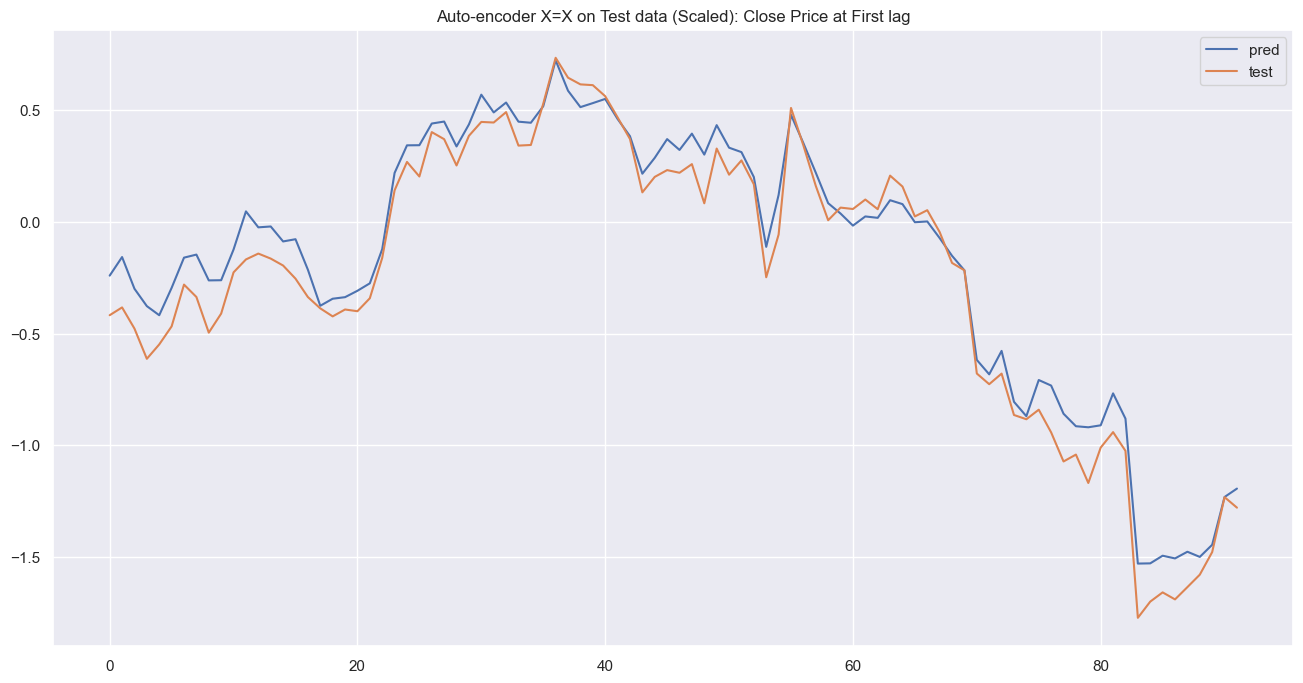

In [71]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [72]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1795.01 1789.42 1785.56 1770.18 1776.6  1781.62 1795.23 1792.8  1784.47]
X test pred :  [1808.75249115 1806.82565159 1799.35546219 1788.37112728 1786.690741
 1794.91535274 1804.53227109 1807.44399306 1802.55921589]


[1795.01 1789.42 1785.56 1770.18 1776.6  1781.62 1795.23 1792.8  1784.47
 1793.61 1805.43 1802.35 1803.18 1803.22 1804.71 1796.62 1797.95 1795.23
 1790.   1790.16 1792.89 1792.89 1807.08 1826.3  1836.73 1830.6  1830.33
 1825.53 1822.95 1829.22 1817.7  1824.26 1826.34 1821.52 1822.85 1833.43
 1829.25 1825.99 1826.92 1825.58 1823.06 1823.46 1825.26 1824.48 1826.95
 1824.04 1826.68 1825.28 1816.86 1820.38 1815.34 1816.83 1815.59 1814.76
 1816.63 1820.7  1823.28 1820.79 1813.19 1811.99 1813.77 1817.68 1814.09
 1821.87 1823.09 1820.6  1818.34 1821.72 1817.17 1817.42 1813.3  1813.93
 1812.84 1797.54 1795.2  1801.52 1797.7  1781.75 1788.38 1786.95 1793.41
 1794.51 1791.09 1771.89 1775.23 1778.34 1777.29 1778.47 1785.87 1794.87
 1812.19 1809.36]
[1808.75249115 1806.82565159 1799.35546219 1788.37112728 1786.690741
 1794.91535274 1804.53227109 1807.44399306 1802.55921589 1805.17502031
 1813.34761534 1818.92767764 1812.22091046 1814.29843736 1813.03580451
 1810.22582287 1807.42727541 1796.1296528

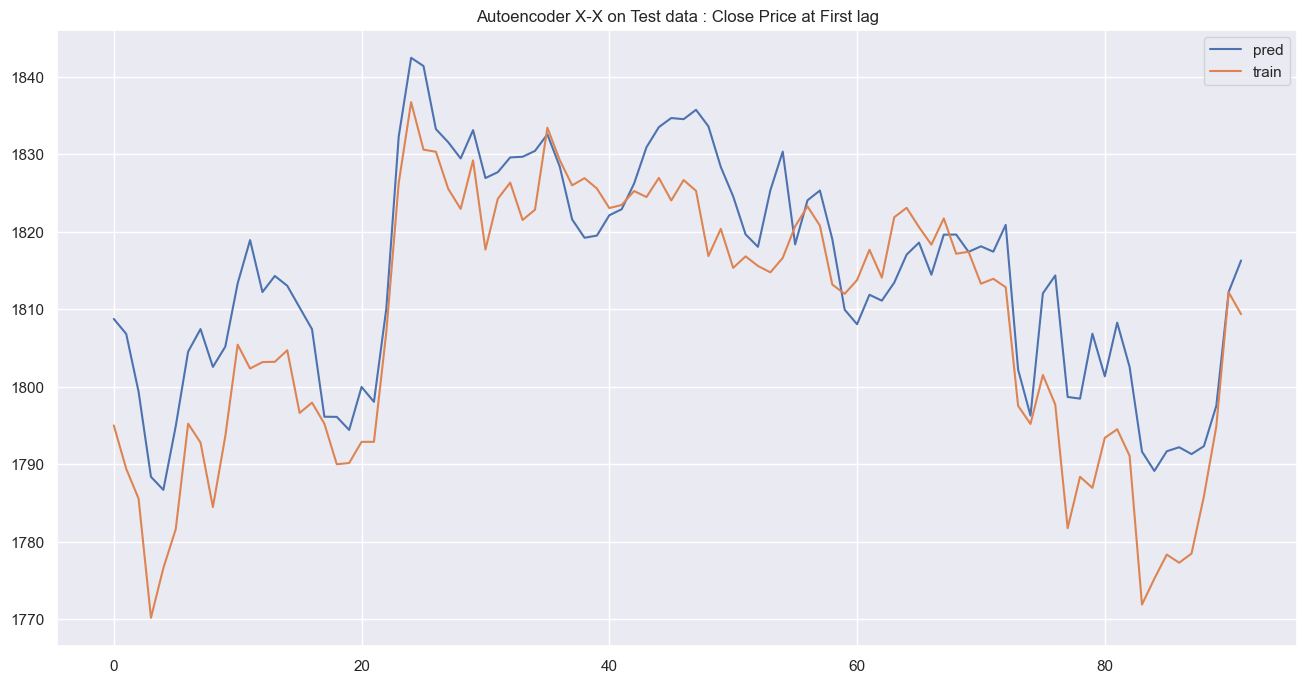

In [73]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [74]:
encoder_model.layers[3].get_weights()

[array([[ 0.20843048,  0.38569432,  0.05439422, ..., -0.60992104,
          0.27552056, -0.35364878],
        [ 0.23345415, -0.20029013,  0.05633791, ..., -0.23989378,
          0.37950096, -0.02134028],
        [ 0.2014565 ,  0.02307282, -0.30237702, ..., -0.0098962 ,
          0.5339931 ,  0.11498127],
        ...,
        [-0.06263138,  0.13027819,  0.17944863, ...,  0.03102488,
          0.03440601, -0.04660263],
        [-0.40362266,  0.20816945,  0.0738749 , ..., -0.34696254,
          0.08564723, -0.12034066],
        [-0.2958416 ,  0.37137246, -0.67279845, ...,  0.15973036,
         -0.7044048 ,  0.3626498 ]], dtype=float32),
 array([ 0.42332196,  0.07324649,  0.0380354 , -0.07246133,  0.11212794,
         0.12895912,  0.34393585,  0.16700278, -0.02285331, -0.21005094,
        -0.21093468, -0.13474141,  0.03195693, -0.02155626,  0.05360812,
        -0.01668497], dtype=float32)]

## Prediction Models

### LSTM all features

In [ ]:
X_train_sca.shape[-1]

104

In [ ]:
X_train_sca.shape[-2:]

(48, 104)

In [121]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100
patience = 10
dropout_rate = 0.01
n_units = 128
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model_1 = tf.keras.models.Sequential()
multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                    return_sequences=False,
                    input_shape=X_train_sca.shape[-2:]))
multi_step_model_1.add(tf.keras.layers.Dropout(dropout_rate))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model_1.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history_1 = multi_step_model_1.fit(
    X_train_sca, y_train_sca, epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])
# eval
mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
mse_curr_1

Epoch 1/100
472/472 [==============================] - 11s 21ms/step - loss: 0.9480 - val_loss: 0.3298
Epoch 2/100
472/472 [==============================] - 9s 20ms/step - loss: 0.7347 - val_loss: 0.3766
Epoch 3/100
472/472 [==============================] - 9s 20ms/step - loss: 0.5431 - val_loss: 0.4014
Epoch 4/100
472/472 [==============================] - 9s 20ms/step - loss: 0.4268 - val_loss: 0.4233
Epoch 5/100
472/472 [==============================] - 9s 20ms/step - loss: 0.3474 - val_loss: 0.4937
Epoch 6/100
472/472 [==============================] - 9s 20ms/step - loss: 0.2957 - val_loss: 0.3555
Epoch 7/100
472/472 [==============================] - 9s 20ms/step - loss: 0.2771 - val_loss: 0.3841
Epoch 8/100
472/472 [==============================] - 9s 20ms/step - loss: 0.2446 - val_loss: 0.4380
Epoch 9/100
472/472 [==============================] - 9s 20ms/step - loss: 0.2300 - val_loss: 0.5909
Epoch 10/100
472/472 [==============================] - 9s 20ms/step - loss: 0.21

0.3298318088054657

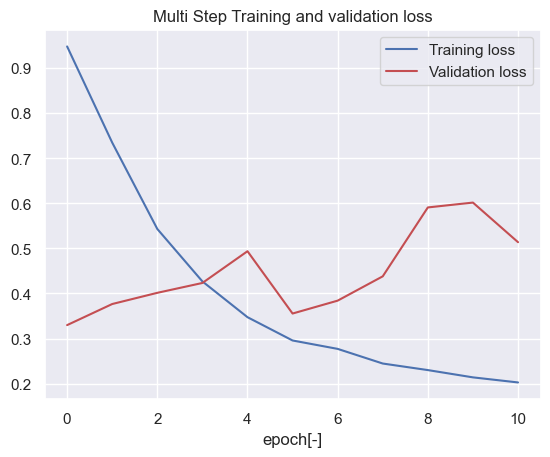

In [124]:
plot_train_history(multi_step_history_1,
                       'Multi Step Training and validation loss', "data")

In [ ]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]

  1/381 [..............................] - ETA: 1:51

2023-04-01 12:48:42.343448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-01 12:48:42.399664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 7ms/step


In [ ]:
y_train_pred_raw_1.shape

(12174, 13)

In [ ]:
y_train_raw.shape

(12174, 13)

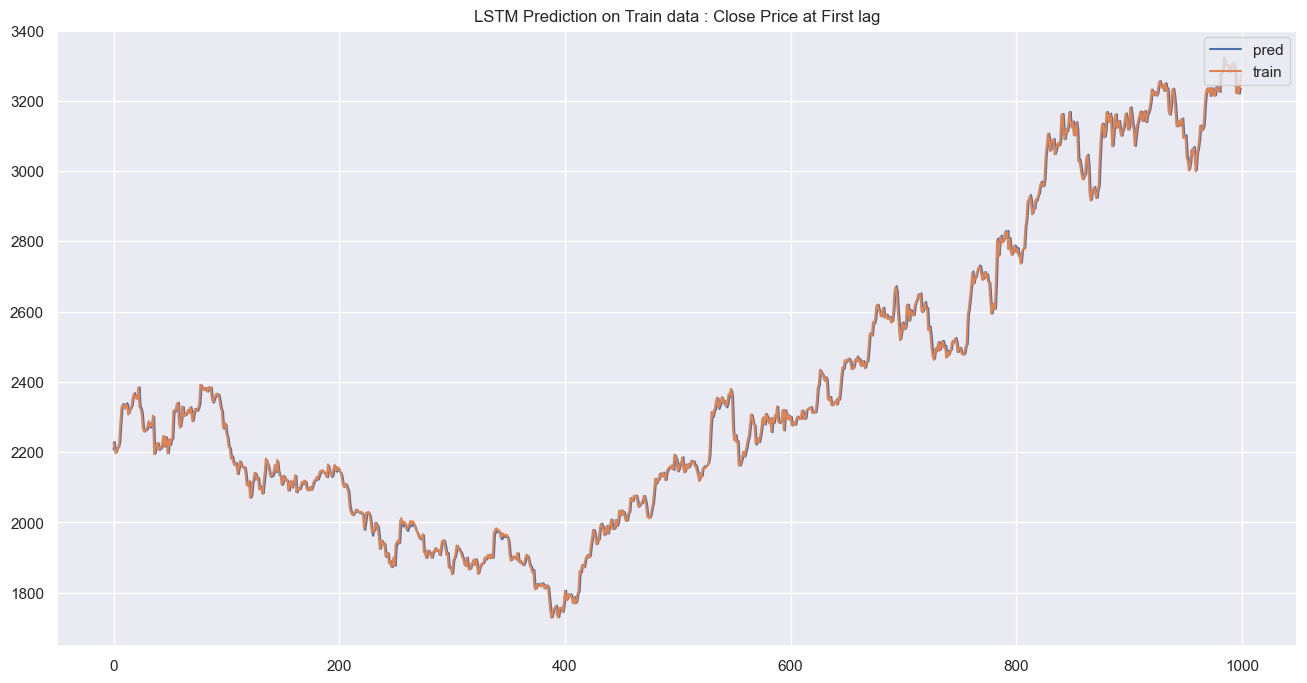

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at First lag")
plt.plot(y_train_pred_raw_1[:1000,0], label="pred")
plt.plot(y_train_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

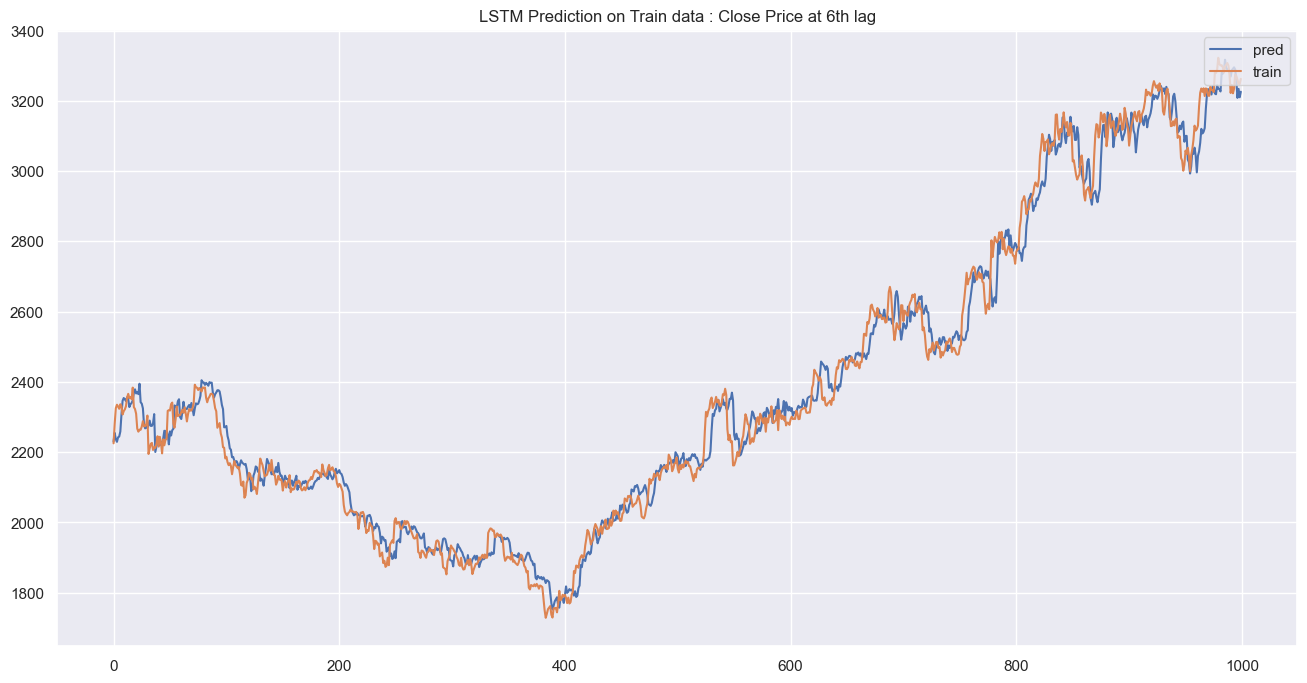

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at 6th lag")
plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
plt.plot(y_train_raw[:1000, 5], label="train")
plt.legend(loc='upper right')

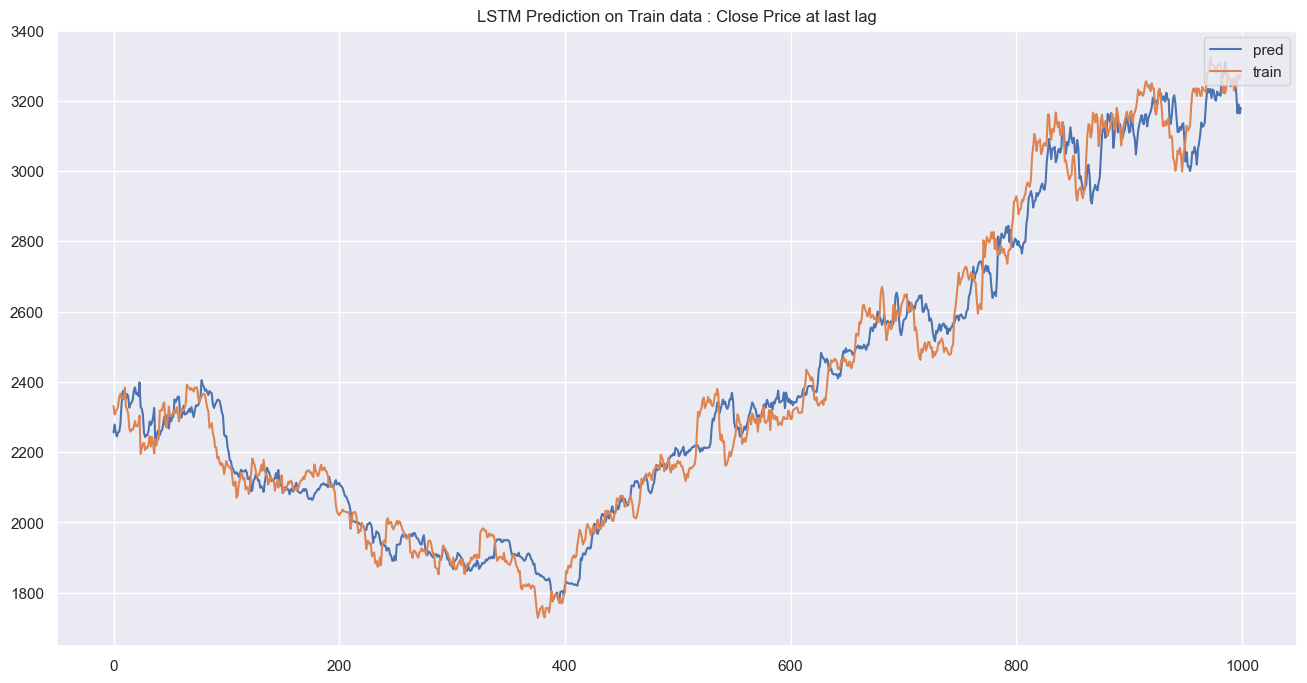

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at last lag")
plt.plot(y_train_pred_raw_1[:1000, -1], label="pred")
plt.plot(y_train_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

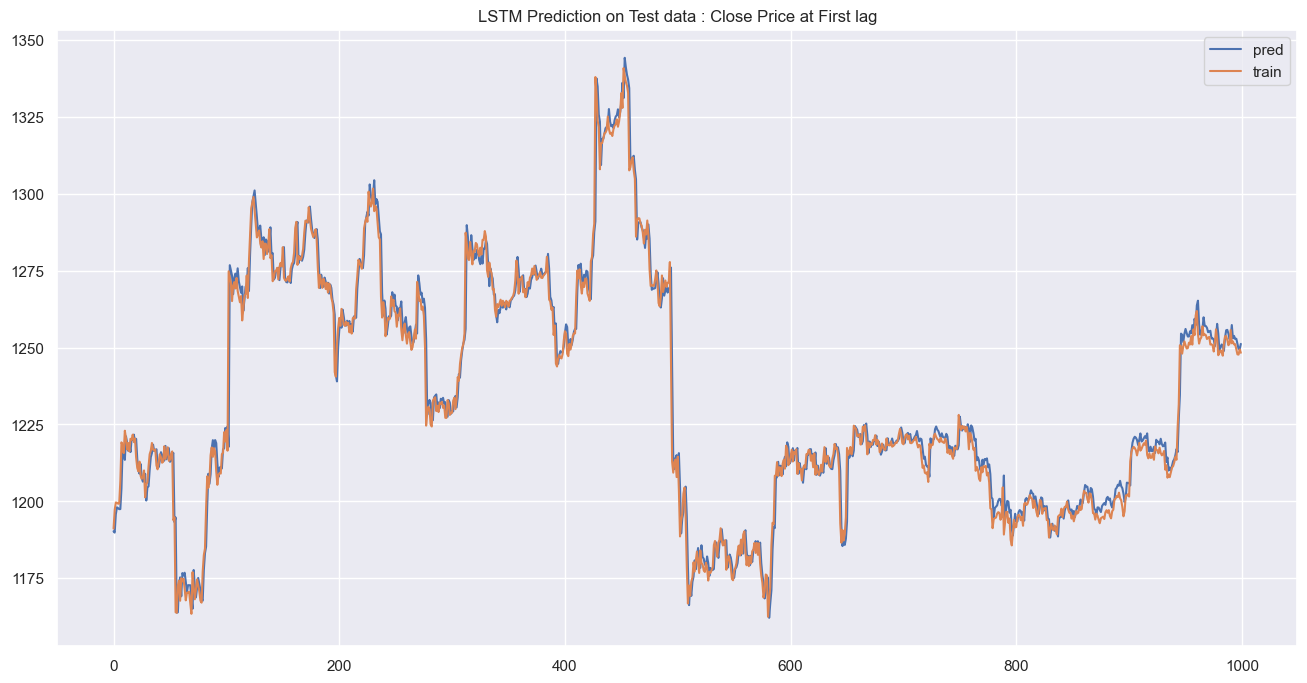

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw_1[:1000,0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

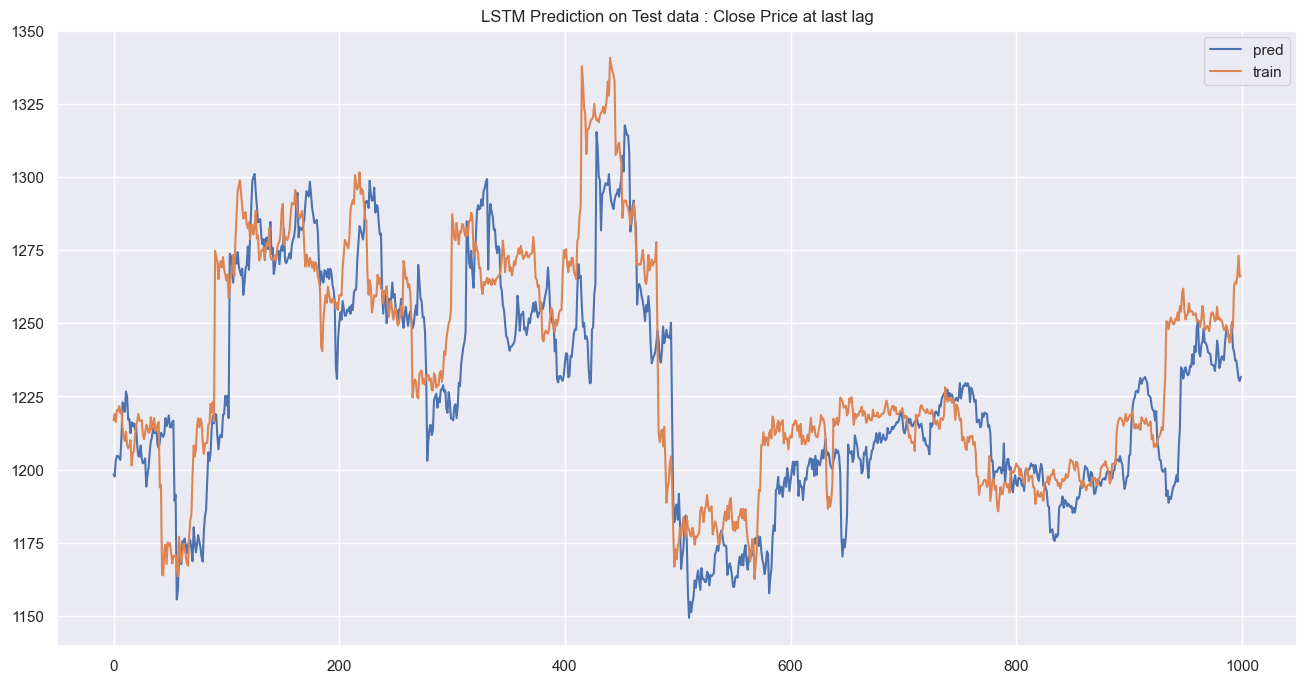

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw_1[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

In [ ]:
y_train_pred_unscaled_1[0,:]

array([1.0009207, 1.0042758, 0.9999173, 1.0048245, 1.0018502, 1.0111582,
       1.008578 , 1.011359 , 1.0074592, 1.0124773, 1.0124305, 1.0012397,
       1.0230651], dtype=float32)

In [ ]:
y_train_pred_unscaled_1[0,:] * X_train_raw[0,-1, 0]

array([2207.6907, 2215.0908, 2205.4775, 2216.3013, 2209.741 , 2230.2712,
       2224.5798, 2230.7139, 2222.1123, 2233.1807, 2233.0774, 2208.3943,
       2256.5337], dtype=float32)

In [ ]:
y_train_pred_raw_1[0,:]

array([2207.69064825, 2215.09095838, 2205.47765447, 2216.30124892,
       2209.74101664, 2230.271257  , 2224.58002542, 2230.71403981,
       2222.11237893, 2233.18063456, 2233.07756397, 2208.39426275,
       2256.53374681])

### Autoencoder + LSTM reduced features

In [74]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

In [76]:
X_train[:,:,0:4].shape

(15218, 48, 4)

In [77]:
list_col_select[0:4]

['Close_ETH', 'Open_ETH', 'High_ETH', 'Low_ETH']

Concatenate 

In [78]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

476/476 [==============================] - 4s 9ms/step


(15218, 48, 16)

In [79]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

3/3 [==============================] - 0s 36ms/step


(92, 48, 16)

In [80]:
# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)

In [81]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((15218, 48, 20), (92, 48, 20))

Train

In [84]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 100
patience = 10
dropout_rate = 0.01
n_units = 64
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(
    n_units,
    return_sequences=False,
    input_shape=X_train_.shape[-2:],
    )
)
multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model.add(tf.keras.layers.LayerNormalization())
multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history = multi_step_model.fit(
    X_train_, y_train_sca, epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_, y_test_sca), 
    verbose=1, 
    callbacks=[es]
)
# eval
mse_curr = np.min(multi_step_history.history['val_loss'])
mse_curr

Epoch 1/100
476/476 [==============================] - 12s 23ms/step - loss: 1.0437 - val_loss: 0.4249
Epoch 2/100
476/476 [==============================] - 10s 22ms/step - loss: 0.8483 - val_loss: 0.2783
Epoch 3/100
476/476 [==============================] - 10s 22ms/step - loss: 0.6703 - val_loss: 0.2843
Epoch 4/100
476/476 [==============================] - 10s 22ms/step - loss: 0.5286 - val_loss: 0.3965
Epoch 5/100
476/476 [==============================] - 10s 22ms/step - loss: 0.4152 - val_loss: 0.2894
Epoch 6/100
476/476 [==============================] - 10s 22ms/step - loss: 0.3390 - val_loss: 0.2715
Epoch 7/100
476/476 [==============================] - 11s 24ms/step - loss: 0.2947 - val_loss: 0.2268
Epoch 8/100
476/476 [==============================] - 11s 24ms/step - loss: 0.2676 - val_loss: 0.2357
Epoch 9/100
476/476 [==============================] - 10s 22ms/step - loss: 0.2457 - val_loss: 0.2147
Epoch 10/100
476/476 [==============================] - 10s 22ms/step - l

0.21472027897834778

### Results

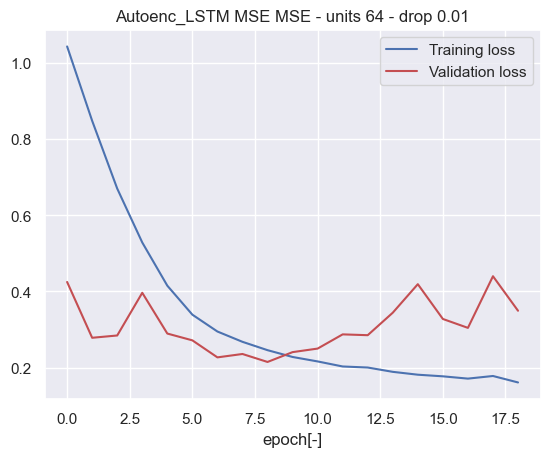

In [85]:
plot_train_history(
    multi_step_history,
    f"Autoenc_LSTM MSE MSE - units {n_units} - drop {dropout_rate}",
    saveFolder="data",
)

Save mdl

In [86]:
multi_step_model.save(path_mdl_predict_autoenc_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


Predict

In [87]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

3/3 [==============================] - 0s 33ms/step


Plots

In [88]:
y_train_pred_raw[0:-1:FUTURE_TARGET,:].shape

(1171, 13)

In [89]:
y_train_pred_raw[0:-1:FUTURE_TARGET,:].ravel().shape

(15223,)

In [90]:
np.array(range(y_train_raw.shape[0])).shape

(15218,)

In [91]:
df_feat["Close_ETH"]

0        2106.41
1        2135.18
2        2087.34
3        2094.46
4        2041.20
          ...   
15427    1900.13
15428    1909.19
15429    1905.75
15430    1911.32
15431    1910.38
Name: Close_ETH, Length: 15432, dtype: float64

In [92]:
y_test_raw

array([[1816.86, 1820.38, 1815.34, ..., 1813.19, 1811.99, 1813.77],
       [1820.38, 1815.34, 1816.83, ..., 1811.99, 1813.77, 1817.68],
       [1815.34, 1816.83, 1815.59, ..., 1813.77, 1817.68, 1814.09],
       ...,
       [1909.96, 1911.  , 1909.3 , ..., 1898.14, 1900.13, 1909.19],
       [1911.  , 1909.3 , 1913.87, ..., 1900.13, 1909.19, 1905.75],
       [1909.3 , 1913.87, 1914.56, ..., 1909.19, 1905.75, 1911.32]])

In [93]:
y_train_raw[0::FUTURE_TARGET,:].ravel()[-100:]

array([1752.59, 1749.57, 1749.12, 1753.24, 1751.91, 1752.55, 1774.75,
       1774.99, 1771.43, 1777.76, 1775.57, 1796.47, 1763.63, 1762.81,
       1756.8 , 1766.97, 1765.99, 1765.82, 1760.35, 1764.12, 1776.08,
       1773.88, 1778.87, 1763.31, 1765.53, 1765.  , 1764.63, 1750.3 ,
       1753.44, 1752.2 , 1756.2 , 1763.38, 1764.96, 1765.42, 1756.1 ,
       1754.93, 1719.75, 1711.74, 1717.42, 1707.92, 1714.52, 1704.58,
       1707.74, 1713.01, 1709.49, 1715.22, 1707.56, 1717.02, 1713.72,
       1711.65, 1718.16, 1724.3 , 1731.44, 1724.53, 1728.07, 1718.7 ,
       1717.58, 1745.48, 1737.05, 1737.6 , 1740.03, 1744.08, 1735.31,
       1736.42, 1777.23, 1785.85, 1774.54, 1769.05, 1770.48, 1772.99,
       1775.24, 1778.47, 1779.42, 1778.07, 1791.85, 1789.67, 1805.06,
       1804.86, 1820.63, 1814.24, 1810.97, 1811.22, 1810.83, 1810.18,
       1796.64, 1807.68, 1793.24, 1798.5 , 1803.81, 1809.02, 1803.47,
       1794.61, 1790.52, 1793.07, 1785.26, 1791.09, 1816.8 , 1787.66,
       1796.82, 1797

In [94]:
y_train_raw[0::FUTURE_TARGET,:].ravel()

array([2226.99, 2206.73, 2196.48, ..., 1787.66, 1796.82, 1797.13])

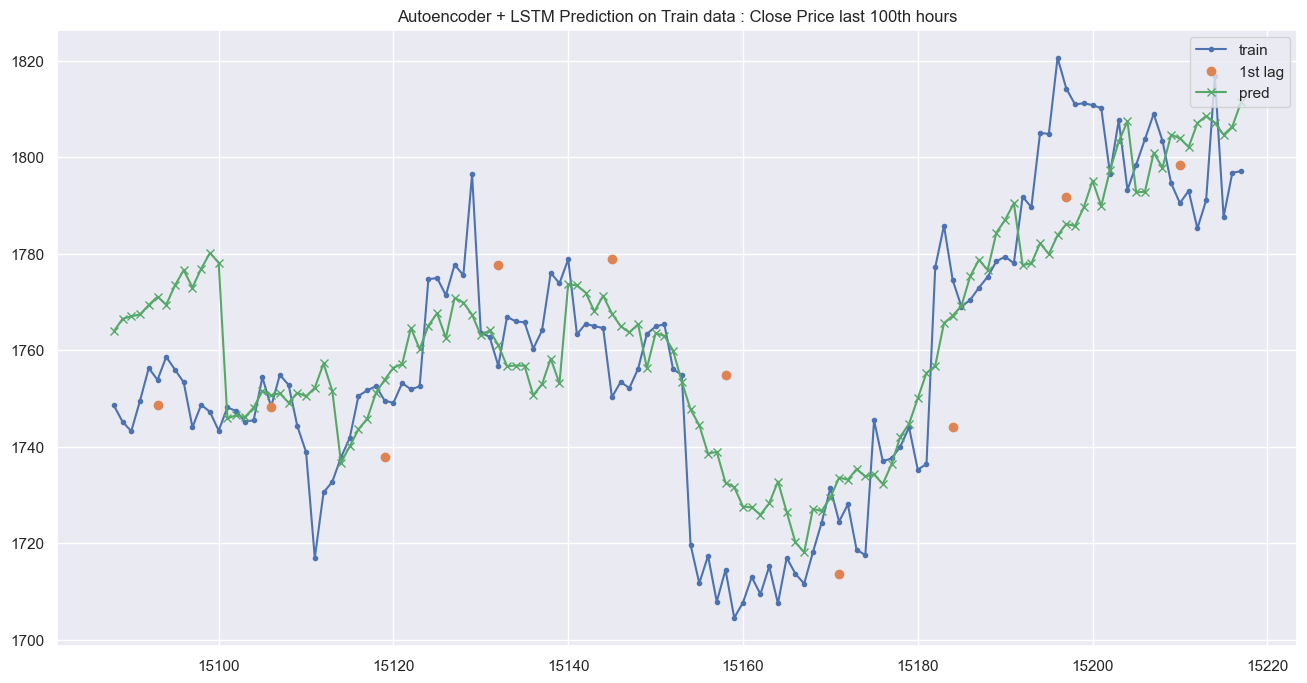

In [95]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on Train data : Close Price last 100th hours")
nb_pred = 10
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.array(range(0, y_train_raw.shape[0], FUTURE_TARGET))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]

plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'o', label ='1st lag')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")

plt.legend(loc='upper right')

In [107]:
y_test_raw.shape

(91, 13)

In [108]:
y_test_raw.shape[0]

91

In [109]:
y_test_raw[0::FUTURE_TARGET,:].ravel().shape

(91,)

In [111]:
np.array(range(0, y_test_raw.shape[0], FUTURE_TARGET)).shape

(7,)

In [112]:
y_test.shape

(91, 13)

In [113]:
y_test_raw.shape

(91, 13)

In [114]:
x_axis_1

array([    0,    13,    26, ..., 15041, 15054, 15067])

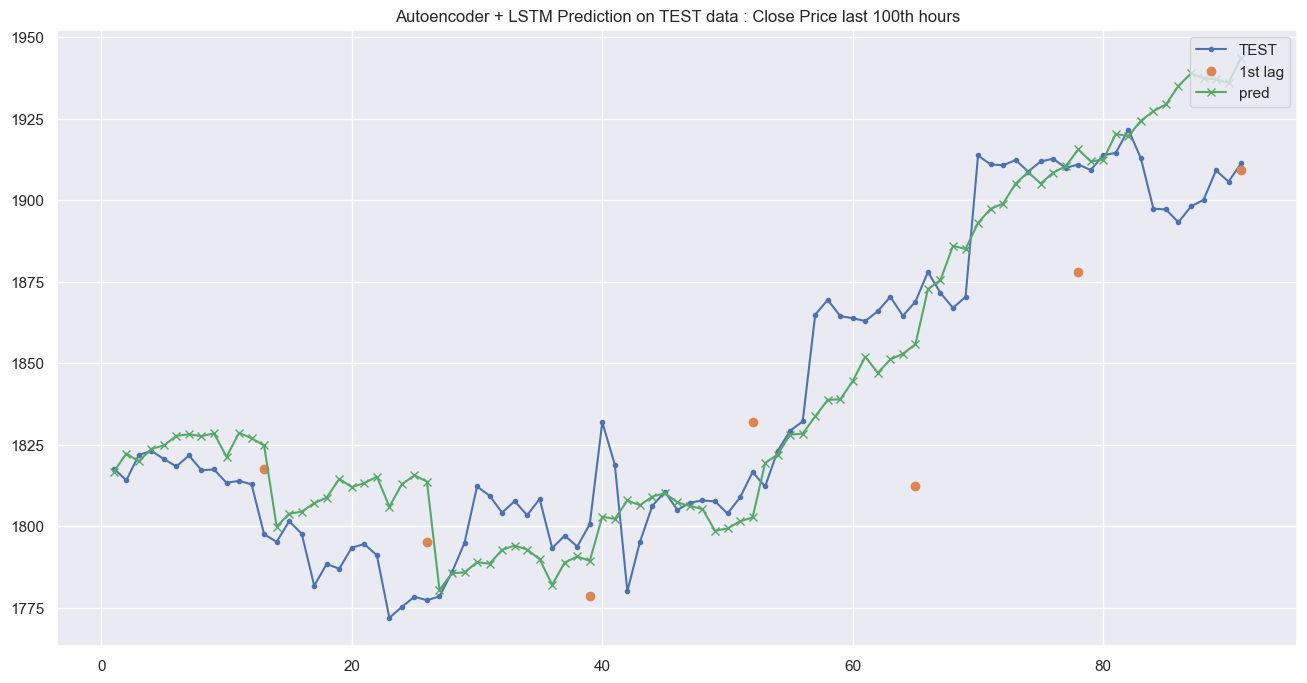

In [96]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on TEST data : Close Price last 100th hours")
nb_pred = 7
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.array(range(0, y_test_raw.shape[0], FUTURE_TARGET))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]

plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="TEST")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'o', label ='1st lag')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")

plt.legend(loc='upper right')

In [261]:
np.array(range(0,y_test_raw.shape[0], FUTURE_TARGET))

array([ 0, 13, 26, 39, 52, 65, 78])

In [262]:
y_test_raw[range(0,y_test_raw.shape[0], FUTURE_TARGET),:]

array([[1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
        1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 ],
       [1763.38, 1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74,
        1717.42, 1707.92, 1714.52, 1704.58, 1707.74, 1713.01],
       [1709.49, 1715.22, 1707.56, 1717.02, 1713.72, 1711.65, 1718.16,
        1724.3 , 1731.44, 1724.53, 1728.07, 1718.7 , 1717.58],
       [1745.48, 1737.05, 1737.6 , 1740.03, 1744.08, 1735.31, 1736.42,
        1777.23, 1785.85, 1774.54, 1769.05, 1770.48, 1772.99],
       [1775.24, 1778.47, 1779.42, 1778.07, 1791.85, 1789.67, 1805.06,
        1804.86, 1820.63, 1814.24, 1810.97, 1811.22, 1810.83],
       [1810.18, 1796.64, 1807.68, 1793.24, 1798.5 , 1803.81, 1809.02,
        1803.47, 1794.61, 1790.52, 1793.07, 1785.26, 1791.09],
       [1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01]])

In [263]:
y_test_raw[:,0]

array([1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
       1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 , 1763.38,
       1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74, 1717.42,
       1707.92, 1714.52, 1704.58, 1707.74, 1713.01, 1709.49, 1715.22,
       1707.56, 1717.02, 1713.72, 1711.65, 1718.16, 1724.3 , 1731.44,
       1724.53, 1728.07, 1718.7 , 1717.58, 1745.48, 1737.05, 1737.6 ,
       1740.03, 1744.08, 1735.31, 1736.42, 1777.23, 1785.85, 1774.54,
       1769.05, 1770.48, 1772.99, 1775.24, 1778.47, 1779.42, 1778.07,
       1791.85, 1789.67, 1805.06, 1804.86, 1820.63, 1814.24, 1810.97,
       1811.22, 1810.83, 1810.18, 1796.64, 1807.68, 1793.24, 1798.5 ,
       1803.81, 1809.02, 1803.47, 1794.61, 1790.52, 1793.07, 1785.26,
       1791.09, 1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47,
       1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01])

In [264]:
y_test_raw[0::FUTURE_TARGET,:].ravel()

array([1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
       1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 , 1763.38,
       1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74, 1717.42,
       1707.92, 1714.52, 1704.58, 1707.74, 1713.01, 1709.49, 1715.22,
       1707.56, 1717.02, 1713.72, 1711.65, 1718.16, 1724.3 , 1731.44,
       1724.53, 1728.07, 1718.7 , 1717.58, 1745.48, 1737.05, 1737.6 ,
       1740.03, 1744.08, 1735.31, 1736.42, 1777.23, 1785.85, 1774.54,
       1769.05, 1770.48, 1772.99, 1775.24, 1778.47, 1779.42, 1778.07,
       1791.85, 1789.67, 1805.06, 1804.86, 1820.63, 1814.24, 1810.97,
       1811.22, 1810.83, 1810.18, 1796.64, 1807.68, 1793.24, 1798.5 ,
       1803.81, 1809.02, 1803.47, 1794.61, 1790.52, 1793.07, 1785.26,
       1791.09, 1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47,
       1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01])

In [253]:
y_test_raw[0::FUTURE_TARGET,:]

array([[1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
        1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 ],
       [1763.38, 1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74,
        1717.42, 1707.92, 1714.52, 1704.58, 1707.74, 1713.01],
       [1709.49, 1715.22, 1707.56, 1717.02, 1713.72, 1711.65, 1718.16,
        1724.3 , 1731.44, 1724.53, 1728.07, 1718.7 , 1717.58],
       [1745.48, 1737.05, 1737.6 , 1740.03, 1744.08, 1735.31, 1736.42,
        1777.23, 1785.85, 1774.54, 1769.05, 1770.48, 1772.99],
       [1775.24, 1778.47, 1779.42, 1778.07, 1791.85, 1789.67, 1805.06,
        1804.86, 1820.63, 1814.24, 1810.97, 1811.22, 1810.83],
       [1810.18, 1796.64, 1807.68, 1793.24, 1798.5 , 1803.81, 1809.02,
        1803.47, 1794.61, 1790.52, 1793.07, 1785.26, 1791.09],
       [1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01]])

In [251]:
y_test_raw[-13:, :]

array([[1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01],
       [1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12, 1800.63,
        1803.53, 1804.62, 1804.21, 1797.69, 1795.01, 1789.42],
       [1796.82, 1797.13, 1796.16, 1806.47, 1799.12, 1800.63, 1803.53,
        1804.62, 1804.21, 1797.69, 1795.01, 1789.42, 1785.56],
       [1797.13, 1796.16, 1806.47, 1799.12, 1800.63, 1803.53, 1804.62,
        1804.21, 1797.69, 1795.01, 1789.42, 1785.56, 1770.18],
       [1796.16, 1806.47, 1799.12, 1800.63, 1803.53, 1804.62, 1804.21,
        1797.69, 1795.01, 1789.42, 1785.56, 1770.18, 1776.6 ],
       [1806.47, 1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69,
        1795.01, 1789.42, 1785.56, 1770.18, 1776.6 , 1781.62],
       [1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01,
        1789.42, 1785.56, 1770.18, 1776.6 , 1781.62, 1795.23],
       [1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01, 

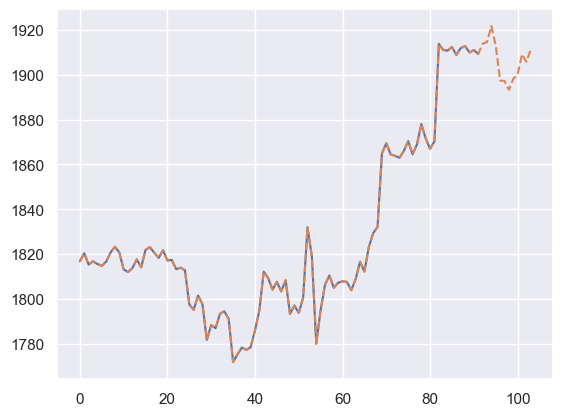

In [97]:
plt.plot(y_test_raw[:,0])
plt.plot(y_test_raw[0::FUTURE_TARGET,:].ravel(),'--')

In [98]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1909.96 1911.   1909.3  1913.87 1914.56 1921.74 1912.9  1897.45 1897.2
 1893.28 1898.14 1900.13 1909.19]
[1914.24346493 1914.28906893 1923.18595144 1922.22461932 1926.32419005
 1929.39174248 1931.88514066 1936.71323514 1941.02076007 1939.73814783
 1939.11656544 1938.73805232 1946.12407463]


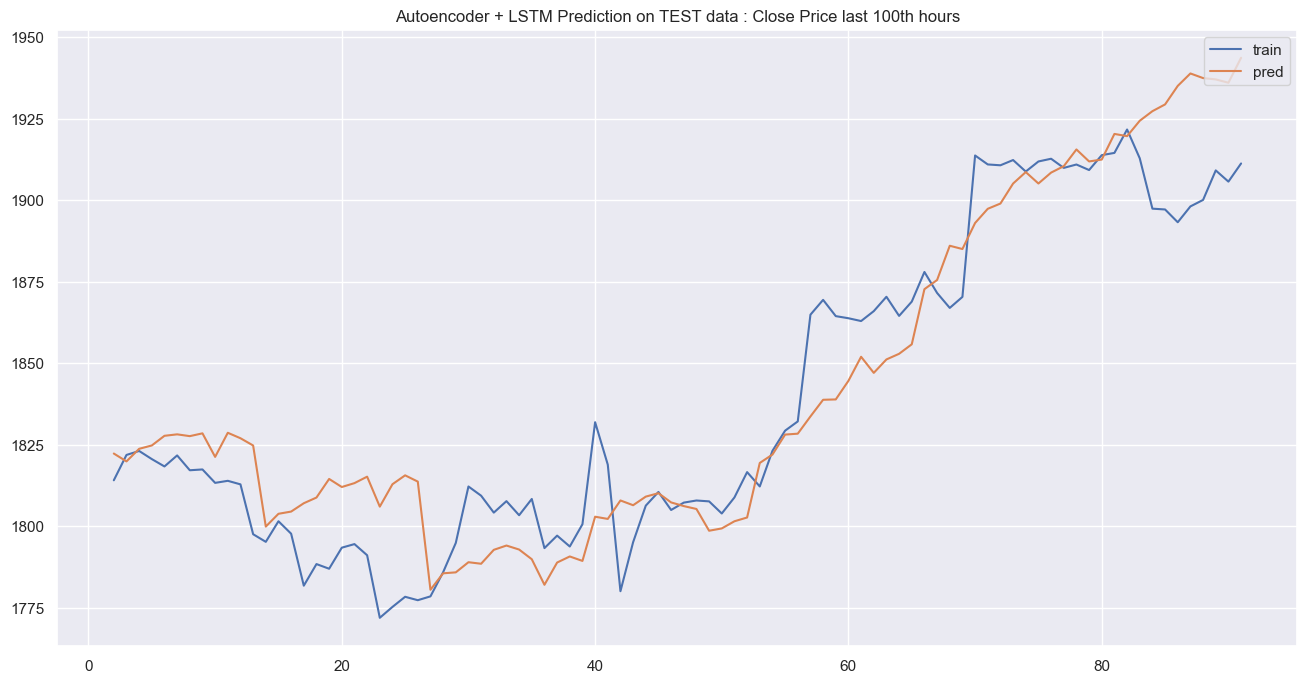

In [101]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on TEST data : Close Price last 100th hours")
x_axis = np.array(range(y_test_raw.shape[0]))
plt.plot(x_axis[-90:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-90:], label="train")
plt.plot(x_axis[-90:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-90:], label="pred")
plt.legend(loc='upper right')

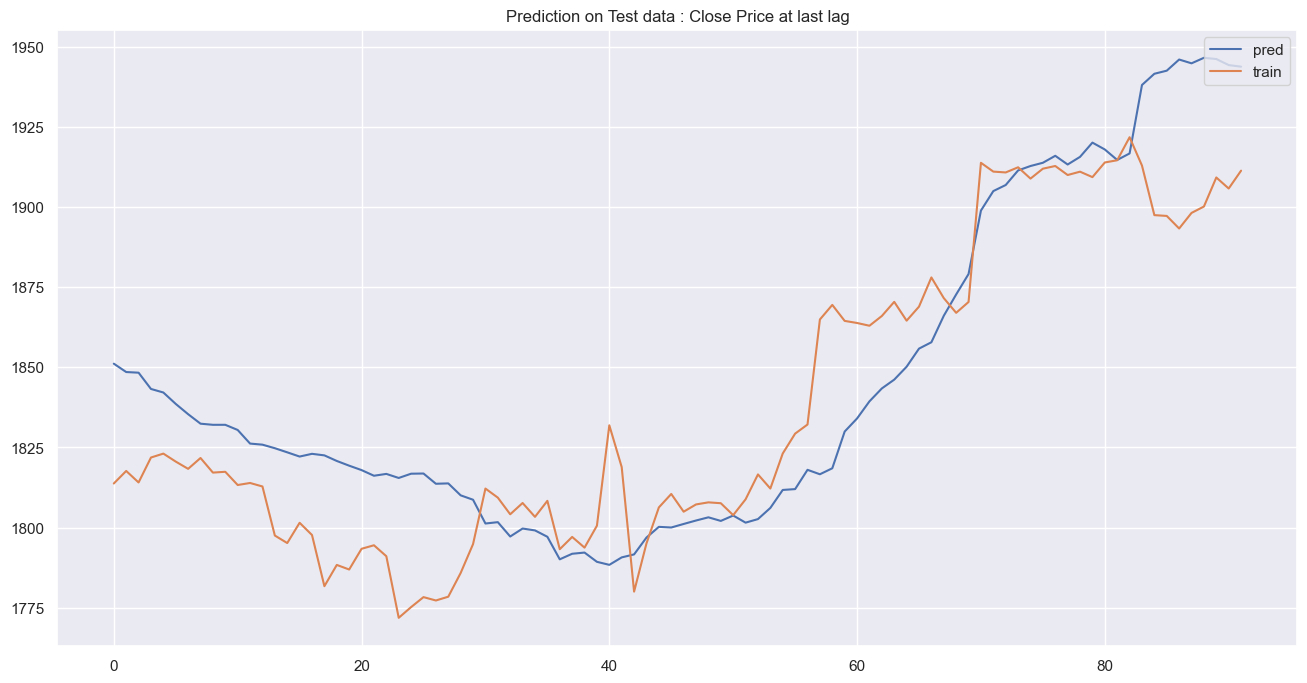

In [102]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

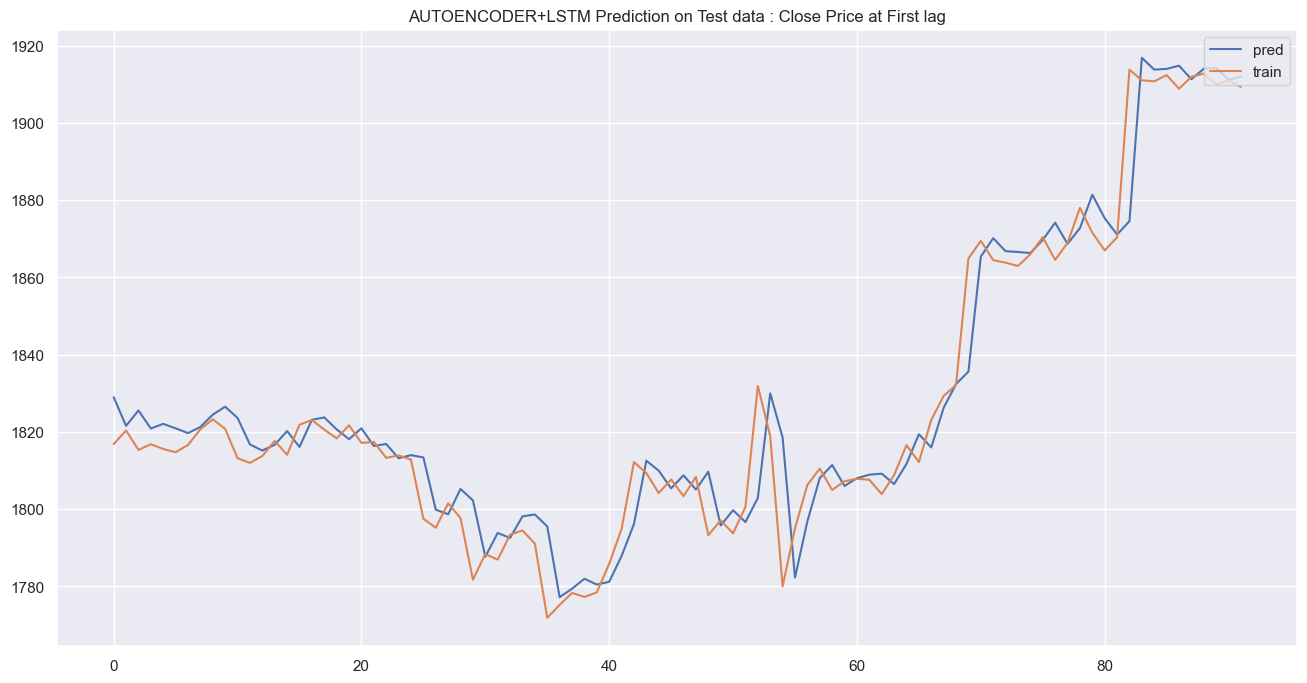

In [103]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

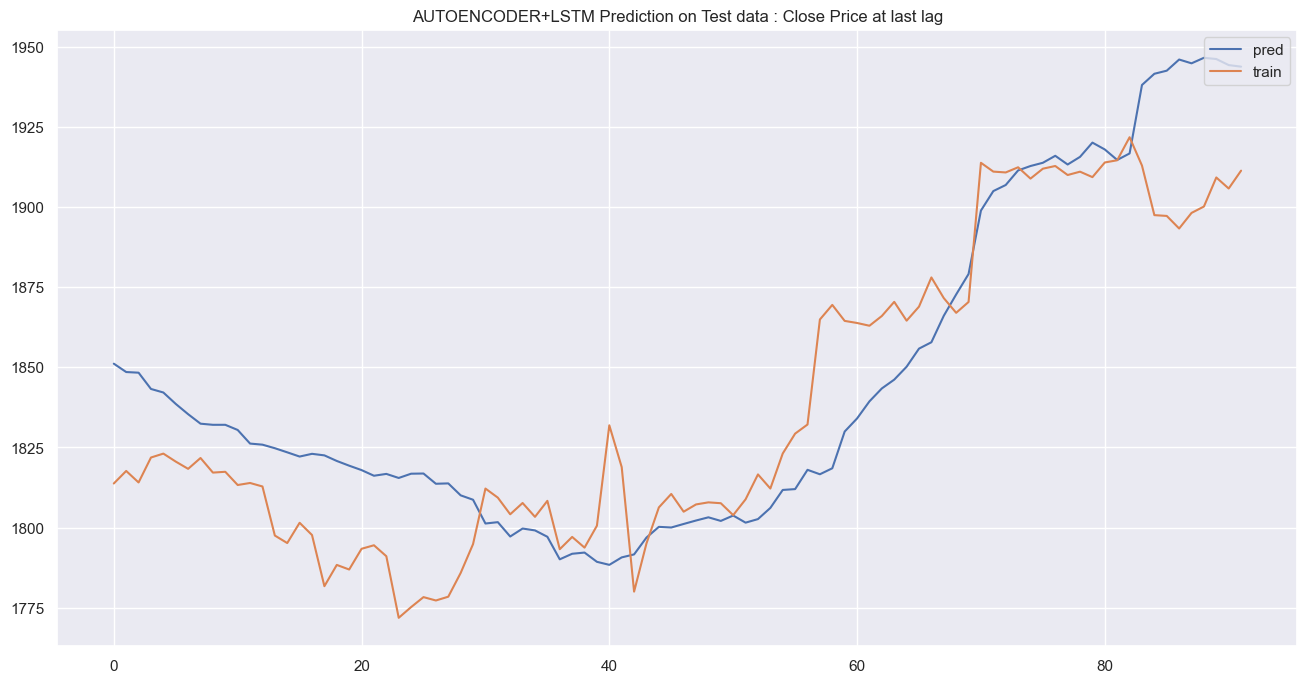

In [104]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

In [125]:
str(time.time())

'1680725792.947519'

## Predict last prediction

In [126]:
X_test_sca.shape

(91, 48, 104)

In [127]:
df_feat["Close_ETH"].iloc[-1]

1802.65

In [140]:
df_feat["Close_ETH"].iloc[-1]

1802.65

In [105]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale py ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate
X_last_ = np.concatenate([X_last_sca[:,:,0:4], X_last_encoded_sca], axis=-1)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))

[batch, lags, features]
X_last[0,:,0]:
[1810.51 1804.98 1807.24 1807.89 1807.62 1803.9  1808.83 1816.6  1812.2
 1823.12 1829.32 1832.16 1864.91 1869.46 1864.47 1863.82 1862.96 1866.
 1870.41 1864.54 1868.92 1878.02 1871.58 1866.99 1870.37 1913.77 1911.02
 1910.76 1912.37 1908.84 1911.93 1912.77 1909.96 1911.   1909.3  1913.87
 1914.56 1921.74 1912.9  1897.45 1897.2  1893.28 1898.14 1900.13 1909.19
 1905.75 1911.32 1910.38]
X_last[0,:,0] after divide by price:
[0.94772244 0.94482773 0.94601074 0.94635099 0.94620965 0.9442624
 0.94684304 0.95091029 0.94860708 0.95432322 0.95756865 0.95905527
 0.97619845 0.97858018 0.97596813 0.97562789 0.97517771 0.97676902
 0.97907746 0.97600477 0.97829751 0.98306096 0.9796899  0.97728724
 0.97905652 1.00177452 1.00033501 1.00019891 1.00104168 0.99919388
 1.00081136 1.00125106 0.99978015 1.00032454 0.99943467 1.00182686
 1.00218805 1.00594646 1.00131911 0.99323171 0.99310085 0.9910489
 0.9935929  0.99463458 0.99937709 0.9975764  1.00049205 1.        ]
(

In [167]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    y_last_pred_raw

## Save last prediction

In [106]:
save_list(list_pred, path_save_pred_vals)

In [107]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [108]:
list_pred_reload

[1915.093,
 1925.0887,
 1926.1559,
 1932.0042,
 1934.5159,
 1936.7509,
 1939.8259,
 1941.6644,
 1938.7642,
 1936.3918,
 1934.4227,
 1938.17]